Prophet is a Python time series forecast library developed by Facebook. Prophet automatically detects yearly, weekly, and daily seasonality. It can quickly decompose the trend and seasonality effects.

In this project, we will make a time-series prediction of Ethereum prices. The following topics will be covered:
* How to train a time series forecasting model using Prophet?
* How to make predictions and do time series decomposition?
* How to identify changing points in the trend?
* How to do time series cross-validation?
* How to evaluate time series model performance using Prophet?

# Step 1: Install And Import Libraries

In the first step, we will install and import libraries. Two Python packages need to be installed, `yfinance` and `prophet`. 


In [1]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

After the package installation, we need to import libraries for this tutorial.

`numpy` and `pandas` are for data processing. `yfinance` is for pulling the data.

Prophet is for building the time series forecast. `.plot` is for model output visualization, and `.diagnostics` is for model performance evaluation.

`plotly` is imported to visualize the Ethereum price trend.


In [3]:
# Data processing
import numpy as np
import pandas as pd

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Visualization
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Step 2: Data Extraction

In the 2nd step, the Ethereum price data is downloaded from the Yahoo finance API. We are using two years' daily data from 2020 and 2021.

Yahoo finance downloads data with the date as an index. Using `reset_index`, we created a new index and used the date as a column. This is because Prophet requires the date-time variable to be a column for the model input.

By default, the date is string type, `pd.to_datetime` changes it to a DateTime format.

In [4]:
# Download Ethereum data
data = yf.download(tickers='ETH-INR', start='2020-01-01', end='2021-12-31', interval = '1d')

# Reset index and have date as a column
data.reset_index(inplace=True)

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

[*********************100%***********************]  1 of 1 completed


In [5]:
# Take a look at the data
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,9242.794922,9465.183594,9218.943359,9316.764648,9316.764648,565210538368
1,2020-01-02,9318.048828,9318.048828,9058.295898,9090.780273,9090.780273,573137797678
2,2020-01-03,9090.856445,9655.730469,9029.173828,9628.295898,9628.295898,751828899741
3,2020-01-04,9628.067383,9763.279297,9547.123047,9692.712891,9692.712891,533249138908
4,2020-01-05,9692.908203,10004.215820,9691.009766,9779.718750,9779.718750,540141680661
...,...,...,...,...,...,...,...
725,2021-12-26,307534.062500,308350.750000,301440.281250,306656.187500,306656.187500,844216179549
726,2021-12-27,306461.531250,309217.656250,302433.437500,302737.500000,302737.500000,856604704973
727,2021-12-28,302736.781250,302736.781250,281464.406250,284074.343750,284074.343750,1292942564491
728,2021-12-29,283816.000000,286147.937500,269408.218750,270581.656250,270581.656250,1172439828295


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       730 non-null    datetime64[ns]
 1   Open       730 non-null    float64       
 2   High       730 non-null    float64       
 3   Low        730 non-null    float64       
 4   Close      730 non-null    float64       
 5   Adj Close  730 non-null    float64       
 6   Volume     730 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 40.0 KB


# Step 3: Visualizing imported data

From the trend chart, we can see that the Ethereum price started to increase after January 2021.

In [7]:
# Declare a figure
fig = go.Figure()
fig.update_layout(
    title_text="Candle Stick plot of Ethereum Data",
)
# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'], 
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Ethereum Data'))

# Step 4: Data Preprocessing

we will forecast the Ethereum close price. Prophet takes two columns as inputs, a datetime column called `ds` and a value column called `y`. Therefore, we need to drop all the other columns, rename `Date` to `ds` and `Close` to `y`.

In [8]:
# Keep only date and close price
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Rename date to ds and close price to y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [9]:
# Take a look at the data
df.head()

,ds,y
0,2020-01-01,9316.764648
1,2020-01-02,9090.780273
2,2020-01-03,9628.295898
3,2020-01-04,9692.712891
4,2020-01-05,9779.718750


Using `.info()`, we can see that the dataset has 731 records and two columns, `ds` and `y`. `ds` is in DateTime format, and `y` is in float format. There is no missing data in the dataset.

In [10]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      730 non-null    datetime64[ns]
 1   y       730 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


# Step 5: Visualizing `ds` and `y`

In [11]:
# plot the close price

x = df["ds"]
y = df["y"]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(
    title_text="Time series plot of Ethereum close Price",
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)

# Step 6: Train Test Split

In step 6, a training and a testing dataset are created. We cannot use random split for time series data because it causes data leakage from the future dates to the past dates. Usually, a cutoff date is selected. The data before the cutoff date is the training dataset, and the data after the cutoff date is used as the testing dataset.

In this example, '2021-11-30' is used as the cutoff date. The first 23 months are used for model training, and the last month is used for testing.

In [12]:
# Train test split
df_train = df[df['ds']<='2021-11-30']
df_test = df[df['ds']>'2021-11-30']

# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 700 records, ranging from 2020-01-01 00:00:00 to 2021-11-30 00:00:00
The testing dataset has 30 records, ranging from 2021-12-01 00:00:00 to 2021-12-30 00:00:00


# Step 7: Train Time Series Model Using Prophet

In step 7, we will train the time series model using the training dataset. 

`interval_width` specifies the prediction interval. We changed the default value of 80% to 95% prediction interval. It makes the upper bound and the lower bound of the prediction broader.

`n_changepoints` is the number of change points in the time series trend. The default value is 25. Based on the shape of the Ethereum, it was set at 7.

In [13]:
# Create the prophet model with confidence internal of 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Fit the model using the training dataset
m.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwgobcoc/l0g43tfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwgobcoc/q7sfmmfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56772', 'data', 'file=/tmp/tmpzwgobcoc/l0g43tfp.json', 'init=/tmp/tmpzwgobcoc/q7sfmmfm.json', 'output', 'file=/tmp/tmpzwgobcoc/prophet_modelz2shc1fi/prophet_model-20230208133641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:36:42 - cmdstanpy - ERROR - Chain [1] 

The yearly seasonality and daily seasonality are automatically disabled. This is because Prophet detects that the dataset we are using does not have full multiple years of data and does not have units smaller than a day.

# Step 8: Using Prophet Model To Make Prediction

Step 8 uses the trained Prophet model to make the prediction. We use the last 31 days to create the future dataframe. This is the same as using the testing dataset we created above.

The prediction output contains lots of information. We kept the predicted value `yhat` and its prediction interval upper and lower bound value. 

In [14]:
# Create a future dataframe for prediction
future = m.make_future_dataframe(periods=31)

# Forecast the future dataframe values
forecast = m.predict(future)

# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
726,2021-12-27,367695.323917,329636.347607,407285.705337
727,2021-12-28,368643.460164,326083.680282,409382.900320
728,2021-12-29,370348.790002,328876.444539,411098.475844
729,2021-12-30,371114.319105,326492.141939,415695.573131
730,2021-12-31,371977.044345,333206.286021,414020.356369


In [15]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
726,2021-12-27,367690.682145,329636.347607,407285.705337,356660.983189,376928.105344,4.641772,4.641772,4.641772,4.641772,4.641772,4.641772,0.0,0.0,0.0,367695.323917
727,2021-12-28,368812.381399,326083.680282,409382.900320,357364.047423,378728.119074,-168.921235,-168.921235,-168.921235,-168.921235,-168.921235,-168.921235,0.0,0.0,0.0,368643.460164
728,2021-12-29,369934.080653,328876.444539,411098.475844,357868.449527,380367.336687,414.709348,414.709348,414.709348,414.709348,414.709348,414.709348,0.0,0.0,0.0,370348.790002
729,2021-12-30,371055.779908,326492.141939,415695.573131,358462.918447,382033.620687,58.539197,58.539197,58.539197,58.539197,58.539197,58.539197,0.0,0.0,0.0,371114.319105
730,2021-12-31,372177.479162,333206.286021,414020.356369,358944.095231,384008.138703,-200.434817,-200.434817,-200.434817,-200.434817,-200.434817,-200.434817,0.0,0.0,0.0,371977.044345


# Step 9: Visualizing the forecast

The x-axis is the date in the forecast visualization, and the y axis is the Ethereum close price. The black dots are the actual prices in the training dataset, and the red dots are the actual forecast prices. The blue line is the time series model prediction. The shaded area is the 95% prediction interval.

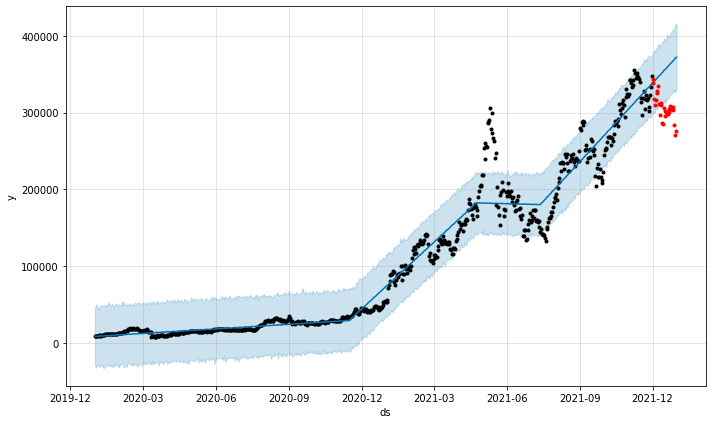

In [16]:
# Visualize the forecast
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

# Step 10: Time Series Decomposition

In step 10, we will decompose the time series forecast. 

From the trend chart, we can see an increasing trend from 2020 December to 2021 December.

The weekly seasonality chart shows that the Ethereum prices decrease starting Monday and reach the lowest on Tuesday. Then the prices started to increase and get the highest on wednesday and reach the lowest on Friday.

In [17]:
# Visualize the components
fig = plot_components_plotly(m, forecast)
fig.update_layout(title_text='Time Series Decomposition(Ethereum)')

# Step 11: Identify Change Points

In step 11, we will discuss how to identify the change points in the time series trend. 

Prophet automatically identifies the change points in time series data following the steps below:
1. Specify the percentage of data used for identifying change points. The default is 80%.
2. Identify a large number of uniformly distributed dates with possible trajectories change. 
3. Apply a sparse prior on the magnitudes of the change rate, which is similar to L1 regularization.

We can list the dates corresponding to the changepoints using `.changepoints`.


In [18]:
# Default change points
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(m.changepoints)]}')

There are 7 change points. 
The change points dates are 
            ds              y
80  2020-03-21   10044.095703
160 2020-06-09   18493.298828
240 2020-08-28   28949.720703
319 2020-11-15   33360.113281
399 2021-02-03  121010.968750
479 2021-04-24  165582.875000
559 2021-07-13  144845.437500


In the visualization, the red dotted lines represent the changepoints. It does not include all the seven changepoints in the chart. Only the ones with more changes are included.

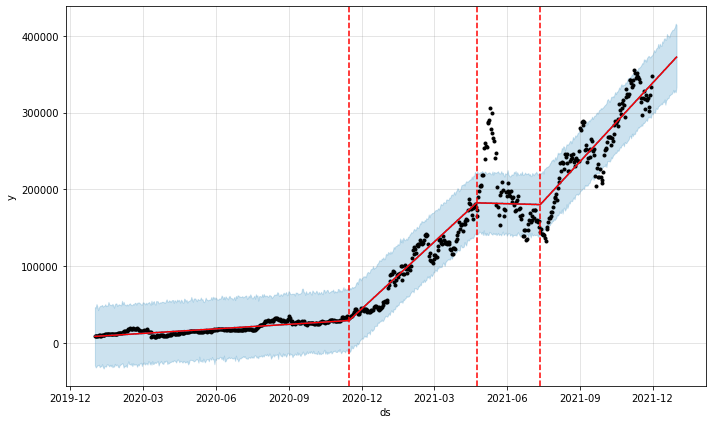

In [19]:
# Change points to plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Step 12: Cross Validation

In step 12, we will do cross-validation for the time series model. Prophet has a `cross_validation` function to automate the comparison between the actual and the predicted values.
* `m` is the trained model.
* `initial='500 days'` means the initial model will be trained on the first 500 days of data.
* `period='60 days'` means 60 days will be added to the training dataset for each additional model.
* `horizon = '30 days'` means that the model forecasts the next 30 days. When only `horizon` is given, Prophet defaults `initial` to be triple the `horizon`, and `period` to be half of the `horizon`.
* `parallel="processes"` enables parallel processing for cross-validation. When the parallel cross-validation can be done on a single machine, "processes" provide the highest performance. For larger problems, "dask" can be used to do cross-validation on multiple machines. 




In [20]:
# Cross validation
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")

INFO:prophet:Making 3 forecasts with cutoffs between 2021-07-03 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed657a130>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwgobcoc/8s1c8h47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwgobcoc/hv97bwex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwgobcoc/f4to249k.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52655', 'data', 'file=/tmp/tmpzwgobcoc/8s1c8h47.json', 'init=/tmp/tmpzwgobcoc/hv97bwex.json', 'output', 'file=/tmp/tmpzwgobcoc/prophet_modeljqfj3alt/prophet_model-20230208133645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwgobcoc/2_s2b4k5.json
DEBU

In [21]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
85,2021-11-26,291123.020740,247799.667081,339116.442188,302531.81250,2021-10-31
86,2021-11-27,291747.462255,244837.654929,339683.472457,307485.53125,2021-10-31
87,2021-11-28,292484.533320,243259.902506,338946.153790,322300.65625,2021-10-31
88,2021-11-29,292605.763499,244953.154266,339521.560322,333628.03125,2021-10-31
89,2021-11-30,292893.184100,245895.899182,342659.707617,347597.81250,2021-10-31


There are 731 days in the dataset. Therefore, after setting the 500 days for the initial model training and 60 days period, there are enough data to train three models and forecast the next 30 days. 

# Step 13: Prophet Model Performance Evaluation

Step 13 evaluates the cross-validation model performance. 
* MSE (Mean Squared Error) sums up the squared difference between actual and prediction and is divided by the number of predictions.
* RMSE (Root Mean Square Error) takes the square root of MSE.
* MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it's undefined when the actual value is zero.
* MDAPE (Median Absolute Percentage Error) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.
* SMAPE (Symmetric Mean Absolute Percentage Error) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

In [22]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3.929038e+09,62682.042701,61009.373709,0.240151,0.247194,0.249730,0.111111
1,4 days,4.280677e+09,65426.882249,63801.760322,0.247843,0.252200,0.258764,0.000000
2,5 days,4.166800e+09,64550.755270,62985.669795,0.249495,0.252200,0.257940,0.000000
3,6 days,3.742177e+09,61173.332446,59808.096922,0.248270,0.252200,0.250181,0.000000
4,7 days,3.503421e+09,59189.706876,58441.381245,0.253515,0.195893,0.248936,0.000000


# Step 13: Visualizing the Performance metrics

`plot_cross_validation_metric` method from Prophet helps us to plot the cross-validation performance results. 

* The x-axis is the horizon. Because we set the horizon to be 30 days, the x-axis has a value up to 30.
* The y-axis is the metric we are interested in. We use `mape` as an example in this visualization. 
* On each day, we can see three dots. This is because there are three models in the cross-validation, and each dot represents the MAPE from one model.
* The line is the aggregated performance across all the models. We can see that MAPE value increases with days, which is expected because time series tend to make better predictions for the near future than the far future.

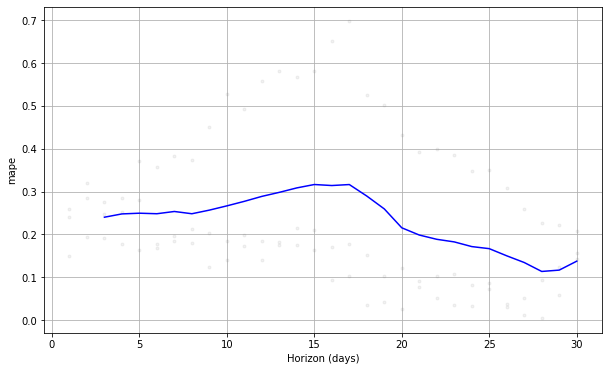

In [23]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')